<a href="https://colab.research.google.com/github/OTeeEnabor/ExchangeRateForecast/blob/main/Arima_Exchange_Rate_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [42]:
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
!pip install pmdarima!pip install pmdarima!pip install pmdarima!pip install pmdarima!pip install pmdarima!pip install pmdarima!pip install pmdarima!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.4 MB/s eta 0:00:00


In [3]:
from pmdarima.arima import auto_arima, ADFTest


Connect Google Sheets 

In [4]:
# authenticating to Google
auth.authenticate_user()
creds,_ = default()
gc =  gspread.authorize(creds)

In [123]:
exchange_sheet = gc.open('Exchange Rate').sheet1
# get all values 
rows = exchange_sheet.get_all_values()
# convert to df
exchange_df = pd.DataFrame(rows)
# show the head of data frame
exchange_df.head()


,0,1,2,3,4,5,6
0,Date/USD,WVT,ITL,ITK,ITN,ITM,ITB
1,Date,South African (Rand),Mauritian Rupee,Kenyan Shilling,Nigerian Naira,Mozambique Metical,Botswana Pula
2,2022-03-12,15.03,44.48,114.16,415.69,63.83,11.56
3,2022-03-13,15.03,44.50,114.19,415.80,63.84,11.56
4,2022-03-14,15.02,44.46,114.01,415.22,63.80,11.55


In [124]:
exchange_df = exchange_df.iloc[1:]
exchange_df.head()

,0,1,2,3,4,5,6
1,Date,South African (Rand),Mauritian Rupee,Kenyan Shilling,Nigerian Naira,Mozambique Metical,Botswana Pula
2,2022-03-12,15.03,44.48,114.16,415.69,63.83,11.56
3,2022-03-13,15.03,44.50,114.19,415.80,63.84,11.56
4,2022-03-14,15.02,44.46,114.01,415.22,63.80,11.55
5,2022-03-15,15.12,44.40,114.25,415.79,63.84,11.62


In [125]:
exchange_df.dtypes

0    object
1    object
2    object
3    object
4    object
5    object
6    object
dtype: object

In [126]:
exchange_df.columns= exchange_df.iloc[0]

In [127]:
exchange_df.columns

Index(['Date', 'South African (Rand)', 'Mauritian Rupee', 'Kenyan Shilling',
       'Nigerian Naira', 'Mozambique Metical', 'Botswana Pula'],
      dtype='object', name=1)

In [128]:
exchange_df = exchange_df.iloc[1:]
exchange_df.head()

1,Date,South African (Rand),Mauritian Rupee,Kenyan Shilling,Nigerian Naira,Mozambique Metical,Botswana Pula
2,2022-03-12,15.03,44.48,114.16,415.69,63.83,11.56
3,2022-03-13,15.03,44.50,114.19,415.80,63.84,11.56
4,2022-03-14,15.02,44.46,114.01,415.22,63.80,11.55
5,2022-03-15,15.12,44.40,114.25,415.79,63.84,11.62
6,2022-03-16,15.08,44.33,114.24,415.74,63.81,11.63


In [129]:
exchange_df[['South African (Rand)', 'Mauritian Rupee', 'Kenyan Shilling','Nigerian Naira', 'Mozambique Metical', 'Botswana Pula']] = exchange_df[['South African (Rand)', 'Mauritian Rupee', 'Kenyan Shilling','Nigerian Naira', 'Mozambique Metical', 'Botswana Pula']].apply(pd.to_numeric)


In [130]:
exchange_df.dtypes

1
Date                     object
South African (Rand)    float64
Mauritian Rupee         float64
Kenyan Shilling         float64
Nigerian Naira          float64
Mozambique Metical      float64
Botswana Pula           float64
dtype: object

In [131]:
exchange_df = exchange_df.reset_index(drop=True)

In [132]:
exchange_df.head()

1,Date,South African (Rand),Mauritian Rupee,Kenyan Shilling,Nigerian Naira,Mozambique Metical,Botswana Pula
0,2022-03-12,15.03,44.48,114.16,415.69,63.83,11.56
1,2022-03-13,15.03,44.50,114.19,415.80,63.84,11.56
2,2022-03-14,15.02,44.46,114.01,415.22,63.80,11.55
3,2022-03-15,15.12,44.40,114.25,415.79,63.84,11.62
4,2022-03-16,15.08,44.33,114.24,415.74,63.81,11.63


In [133]:
exchange_df['Date'] = pd.to_datetime(exchange_df['Date'])

In [134]:
exchange_df.rename(columns = 
                   {"South African (Rand)": "ZAR",
                    "Mauritian Rupee": "MUR",
                    "Kenyan Shilling": "KSH",
                    "Nigerian Naira": "NRA",
                    "Mozambique Metical":"MZM",
                    "Botswana Pula": "BPU"}, inplace=True)

In [135]:
exchange_df.head()

1,Date,ZAR,MUR,KSH,NRA,MZM,BPU
0,2022-03-12,15.03,44.48,114.16,415.69,63.83,11.56
1,2022-03-13,15.03,44.50,114.19,415.80,63.84,11.56
2,2022-03-14,15.02,44.46,114.01,415.22,63.80,11.55
3,2022-03-15,15.12,44.40,114.25,415.79,63.84,11.62
4,2022-03-16,15.08,44.33,114.24,415.74,63.81,11.63


# Distribution Plots

In [136]:
currency_list = ['ZAR', 'MUR', 'KSH', 'NRA','MZM','BPU']

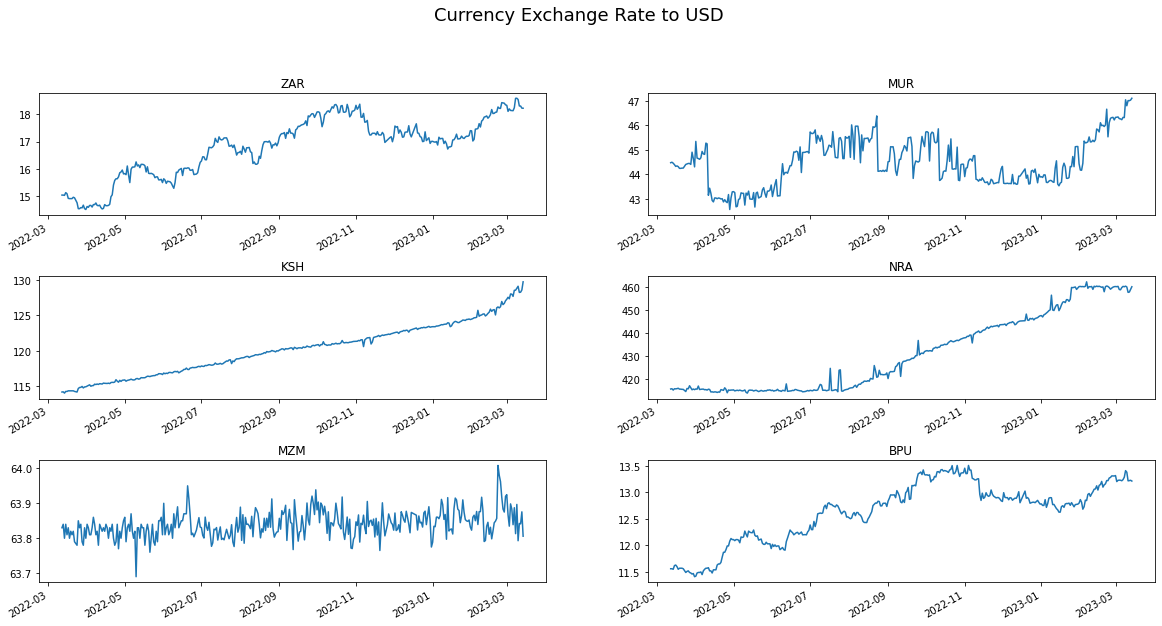

In [137]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Currency Exchange Rate to USD', fontsize=18,y=1)

# loop through the length of currencies and keep track of index
for n, currency in enumerate(currency_list):
  # add new subplot iteratively
  ax = plt.subplot(3,2,n+1)
  exchange_df.plot(x='Date',y=currency,ax=ax, legend=None)
  # chart formating
  ax.set_title(currency.upper())
  # ax.get_legend().remove()
  ax.set_xlabel("")
  # chart formating
  ax.set_title(currency.upper())
  # ax.get_legend().remove()
  ax.set_xlabel("")


## Determine Stationarity
Is it a stationary series?
1. The mean of the time series should not be a finction of time. It should be constant.
2. The variance of the time series should not be a function of time.
3. The covariance of the ith term and the (i+m)th term should not be a function of time.

The statistical properties over time frame have to be constant and autocovariance must not fluctuate with time. 
 
 ## Resample the data
Daily data for time series usually contains too much variation. Therefore, each series will be resampled by week. This resampled time series will be used to predict the exchange rate against the USD.

In [138]:
# to resample the index of exchange df must be in date time
exchange_df.set_index('Date', inplace=True)

In [139]:
# initialize an empty dataframe for the weekly sample
week_exchange_df = pd.DataFrame()


In [140]:
for i in range(len(currency_list)):
  week_series = exchange_df[currency_list[i]].resample('W').mean()
  week_exchange_df[currency_list[i]] = week_series.values
  if i == len(currency_list) - 1:
    week_exchange_df['Date'] = week_series.index
    week_exchange_df.set_index('Date', inplace=True)



In [141]:
week_exchange_df.head()

,ZAR,MUR,KSH,NRA,MZM,BPU
Date,,,,,,
2022-03-13,15.030000,44.490000,114.175000,415.745000,63.835000,11.560000
2022-03-20,14.975714,44.337143,114.257143,415.692857,63.815714,11.584286
2022-03-27,14.741429,44.360000,114.467143,415.705714,63.814286,11.528571
2022-04-03,14.584286,44.707143,114.958571,415.841429,63.811429,11.458571
2022-04-10,14.661429,44.918571,115.160000,415.467143,63.821429,11.521429


In [142]:
week_exchange_df['ZAR'].name

'ZAR'

### Perform Dickey Fuller test

#### Stationarity Check 

The Dickey Fuller test is used to check the stationarity of the series. The test determines how stringly a time series is defined by a trend. The null hypothesis of the test is that time series is not stationary( has some time-dependent structure). 

The test result is made up of a Test Statistic and some Critical Values for different confidence levels. If **P-VALUE** is less than the **significance level** , the null hypothesis is rejected and the series is stationary.

In [143]:
def stationarity_check(date,timeseries):
  # determine the rolling statistics
  rolling_mean = timeseries.rolling(window=10, center=False).mean()
  rolling_std = timeseries.rolling(window=10, center=False).std()
  # plot rolling statistics
  standard = plt.plot(date, timeseries, color='blue', label='original' )
  mean = plt.plot(date, rolling_mean, color='red', label='mean-mean' )
  std = plt.plot(date, rolling_std, color='black', label='std-rolling')
  plt.legend(loc='best')
  plt.title(f'Rolling Mean & standard deviation for {timeseries.name}/USD ')
  plt.show(block=False)
  #Perform Dickey-Fuller test:
  print ('Results of Dickey-Fuller Test:')
  dickey_fuller_test = adfuller(timeseries, autolag='AIC')
  dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dickey_fuller_test[4].items():
    dfresults['Critical Value (%s)'%key] = value
  print (dfresults)

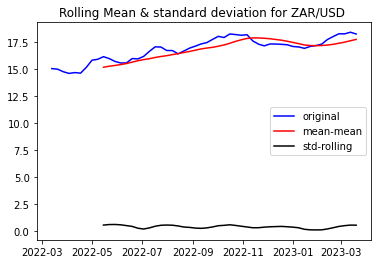

Results of Dickey-Fuller Test:
Test Statistic                 -1.611493
p-value                         0.477192
#Lags Used                      1.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


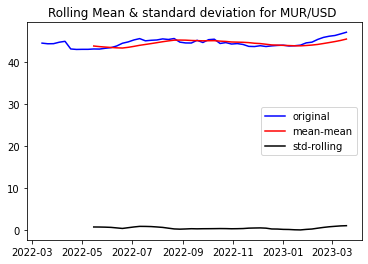

Results of Dickey-Fuller Test:
Test Statistic                 -0.568081
p-value                         0.878033
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


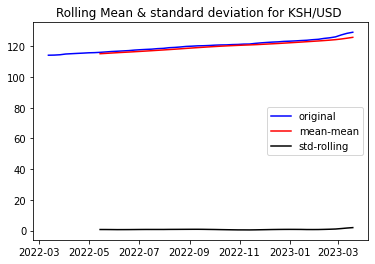

Results of Dickey-Fuller Test:
Test Statistic                  1.714365
p-value                         0.998163
#Lags Used                      1.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


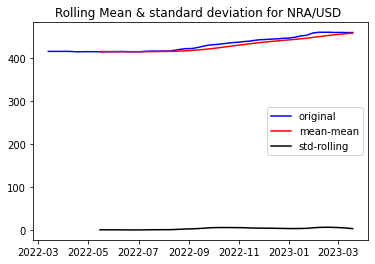

Results of Dickey-Fuller Test:
Test Statistic                  0.361697
p-value                         0.980005
#Lags Used                      1.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


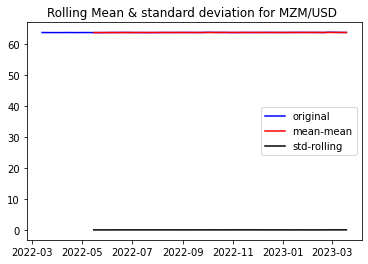

Results of Dickey-Fuller Test:
Test Statistic                 -4.010229
p-value                         0.001358
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


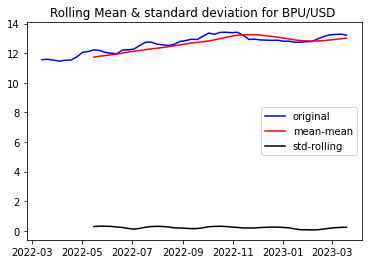

Results of Dickey-Fuller Test:
Test Statistic                 -1.753961
p-value                         0.403546
#Lags Used                      1.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [144]:
for currency in currency_list:
  stationarity_check(week_exchange_df.index, week_exchange_df[currency])

Based on the results of the stationarity task,** AR, MUR, KSH, NRA, and BPU** time series are not stationary due to the p-value being **greater than 5%**. ACF plots were created for each time series to further verify the non-stationarity. 

The ACF plots show us that the majority of these time series data is not stationary. For a stationary time series, the ACF plot will drop to zero relatively quickly, while ACF for non-stationary series descreases slowly.


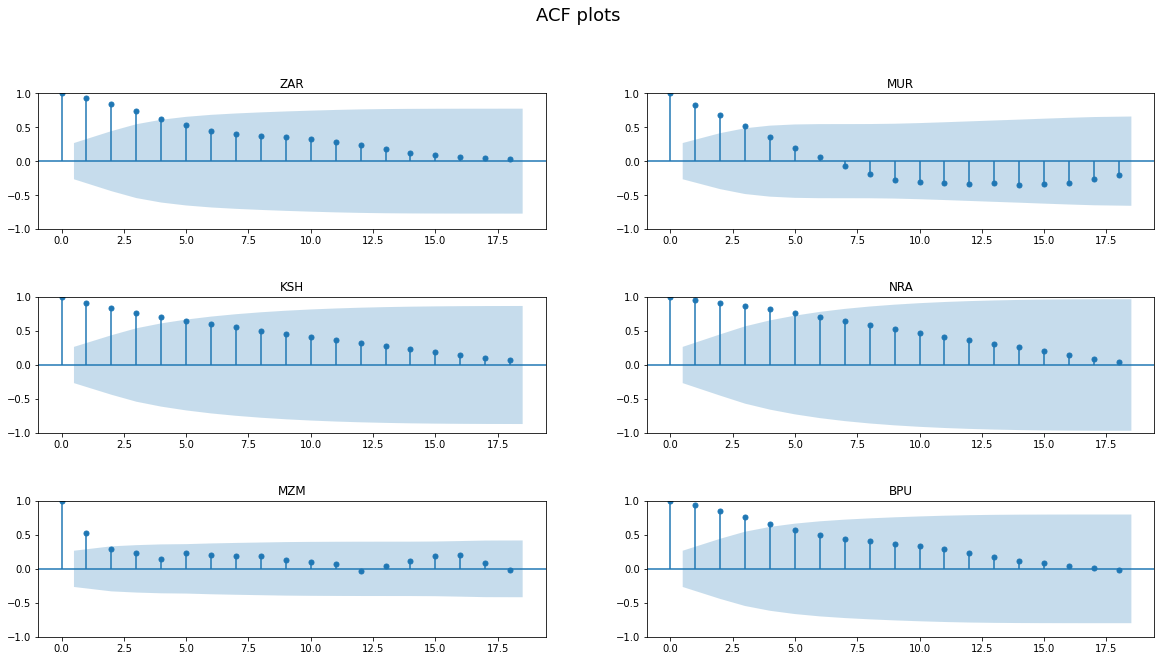

In [145]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('ACF plots', fontsize=18,y=1)

# loop through the length of currencies and keep track of index
for n, currency in enumerate(currency_list):
  # add new subplot iteratively
  ax = plt.subplot(3,2,n+1)
  plot_acf(x=week_exchange_df[currency],ax=ax)
  # chart formating
  ax.set_title(currency.upper())
  # ax.get_legend().remove()
  ax.set_xlabel("")

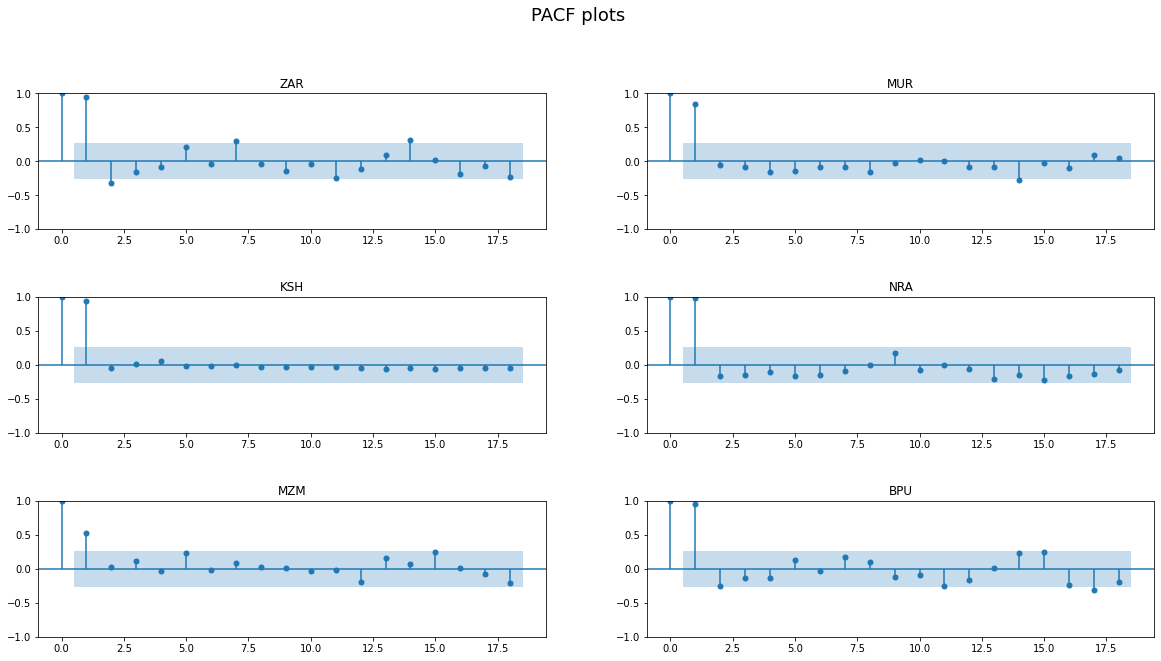

In [146]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('PACF plots', fontsize=18,y=1)

# loop through the length of currencies and keep track of index
for n, currency in enumerate(currency_list):
  # add new subplot iteratively
  ax = plt.subplot(3,2,n+1)
  plot_pacf(x=week_exchange_df[currency],ax=ax)
  # chart formating
  ax.set_title(currency.upper())
  # ax.get_legend().remove()
  ax.set_xlabel("")

Lets see the seasonal and trend components of each time series.

In [147]:
non_stationary_currency_list = ['ZAR', 'MUR', 'KSH','NRA', 'BPU']


ZAR
MUR
KSH
NRA
MZM
BPU


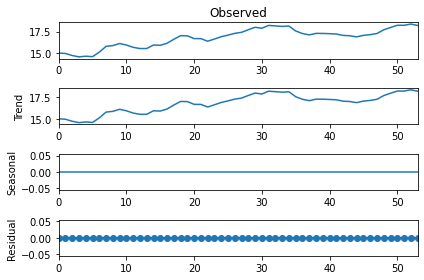

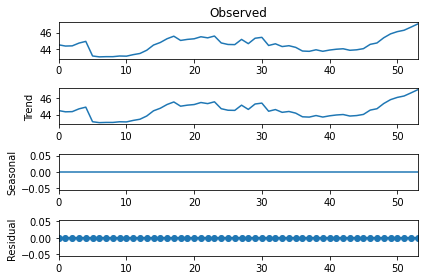

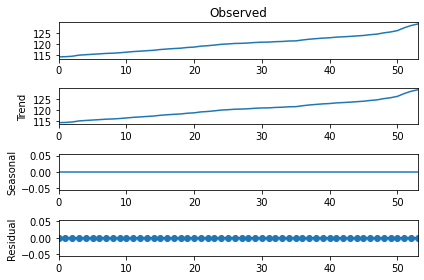

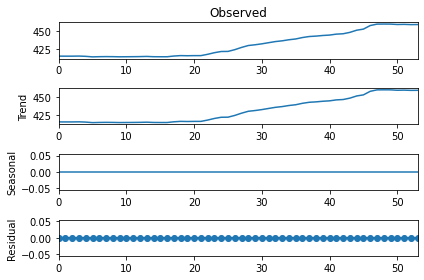

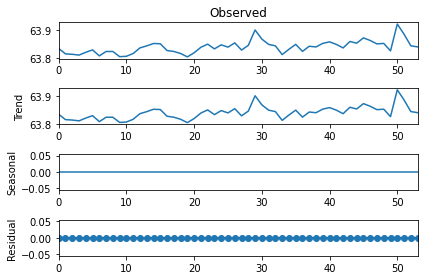

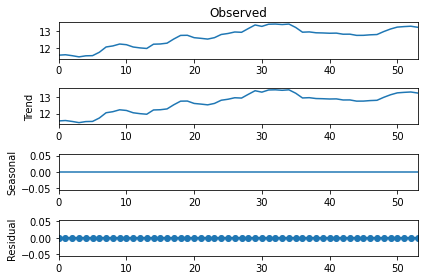

In [148]:
for n, currency in enumerate(currency_list):
  result = seasonal_decompose(week_exchange_df[currency].tolist(), model='additive', period=1)
  print(currency)
  result.plot()

Lets apply log transformation to each time series to remove the trend component.

In [149]:
for n, currency in enumerate(currency_list):
  week_exchange_df[f'{currency}_log'] = np.log(week_exchange_df[currency])

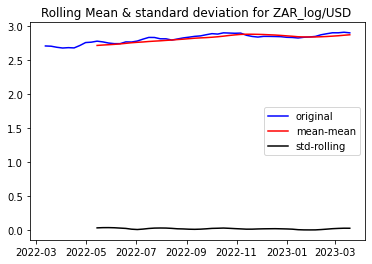

Results of Dickey-Fuller Test:
Test Statistic                 -1.665801
p-value                         0.448813
#Lags Used                      1.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


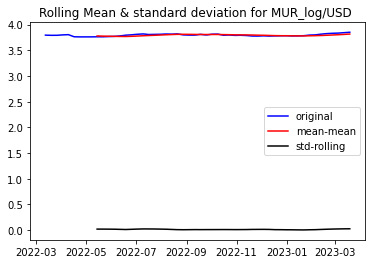

Results of Dickey-Fuller Test:
Test Statistic                 -0.620764
p-value                         0.866221
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


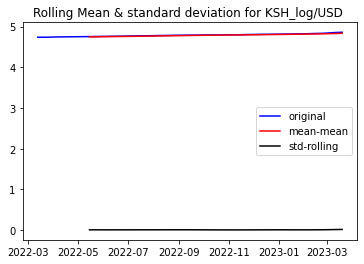

Results of Dickey-Fuller Test:
Test Statistic                  1.590827
p-value                         0.997830
#Lags Used                      1.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


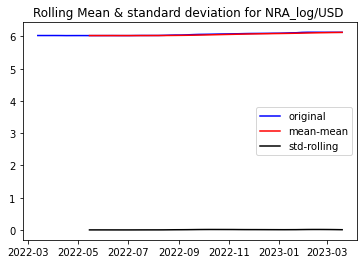

Results of Dickey-Fuller Test:
Test Statistic                  0.327690
p-value                         0.978580
#Lags Used                      1.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


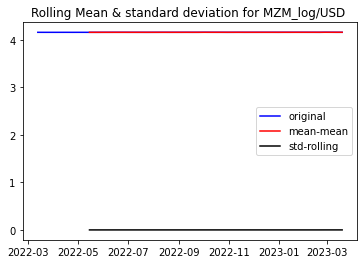

Results of Dickey-Fuller Test:
Test Statistic                 -4.009565
p-value                         0.001361
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


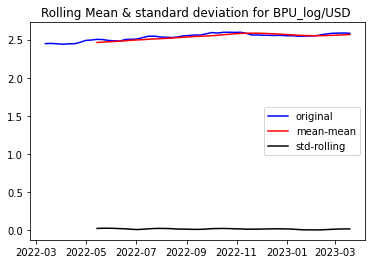

Results of Dickey-Fuller Test:
Test Statistic                 -1.787018
p-value                         0.386925
#Lags Used                      1.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [150]:
for currency in currency_list:
  stationarity_check(week_exchange_df.index, week_exchange_df[f'{currency}_log'])

In [151]:
for n,currency in enumerate(currency_list):
  week_exchange_df[f'{currency}_log_dif'] = week_exchange_df[f'{currency}_log'] - week_exchange_df[f'{currency}_log'].shift()

In [152]:
week_exchange_df.columns

Index(['ZAR', 'MUR', 'KSH', 'NRA', 'MZM', 'BPU', 'ZAR_log', 'MUR_log',
       'KSH_log', 'NRA_log', 'MZM_log', 'BPU_log', 'ZAR_log_dif',
       'MUR_log_dif', 'KSH_log_dif', 'NRA_log_dif', 'MZM_log_dif',
       'BPU_log_dif'],
      dtype='object')

In [153]:
week_exchange_df= week_exchange_df.fillna(0)

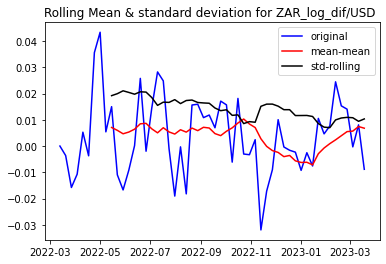

Results of Dickey-Fuller Test:
Test Statistic                 -4.812361
p-value                         0.000052
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


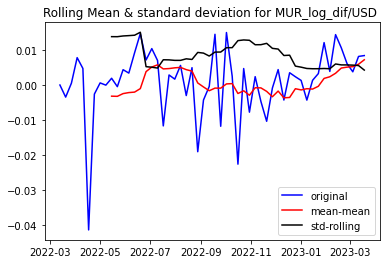

Results of Dickey-Fuller Test:
Test Statistic                -6.893767e+00
p-value                        1.334986e-09
#Lags Used                     0.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


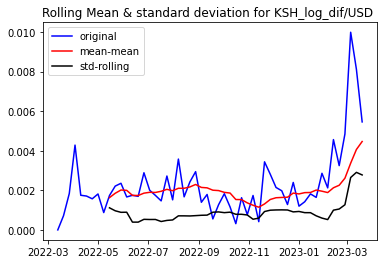

Results of Dickey-Fuller Test:
Test Statistic                 -3.088929
p-value                         0.027383
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


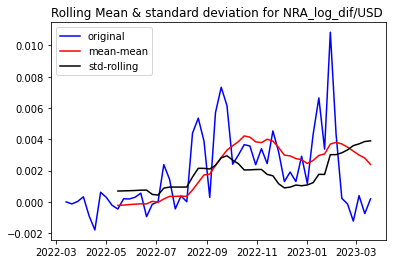

Results of Dickey-Fuller Test:
Test Statistic                 -3.608377
p-value                         0.005603
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


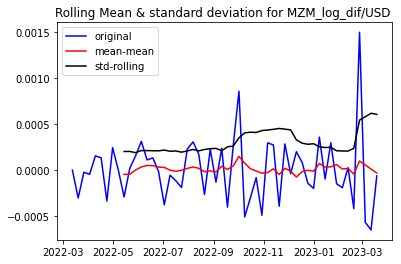

Results of Dickey-Fuller Test:
Test Statistic                -6.137346e+00
p-value                        8.126698e-08
#Lags Used                     3.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64


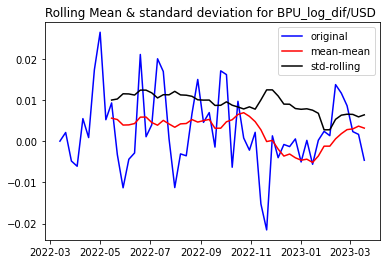

Results of Dickey-Fuller Test:
Test Statistic                 -4.891377
p-value                         0.000036
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [154]:
for currency in currency_list:
  stationarity_check(week_exchange_df.index, week_exchange_df[f'{currency}_log_dif'])

## Plot ACF and PACF Plots

Now that each time series has been stationarized, time to use the PACF and ACF plots to determine the PDQ terms for the ARIMA model.

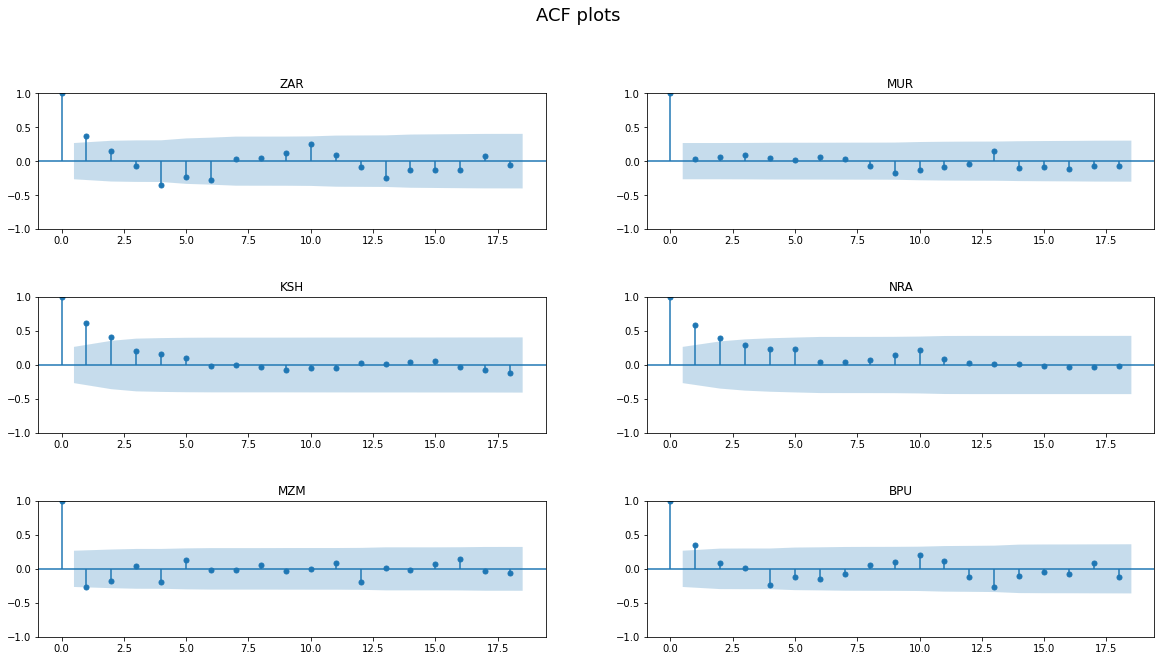

In [155]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('ACF plots', fontsize=18,y=1)

# loop through the length of currencies and keep track of index
for n, currency in enumerate(currency_list):
  # add new subplot iteratively
  ax = plt.subplot(3,2,n+1)
  plot_acf(x=week_exchange_df[f'{currency}_log_dif'],ax=ax)
  # chart formating
  ax.set_title(currency.upper())
  # ax.get_legend().remove()
  ax.set_xlabel("")

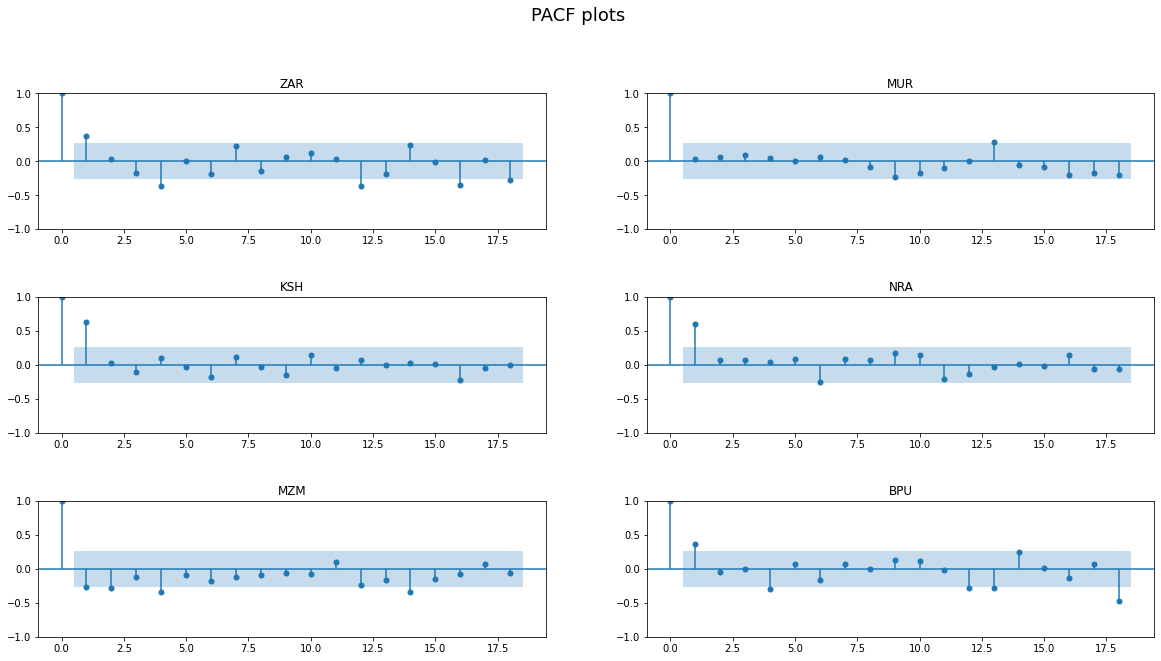

In [156]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('PACF plots', fontsize=18,y=1)

# loop through the length of currencies and keep track of index
for n, currency in enumerate(currency_list):
  # add new subplot iteratively
  ax = plt.subplot(3,2,n+1)
  plot_pacf(x=week_exchange_df[f'{currency}_log_dif'],ax=ax)
  # chart formating
  ax.set_title(currency.upper())
  # ax.get_legend().remove()
  ax.set_xlabel("")

# Predict with Arima

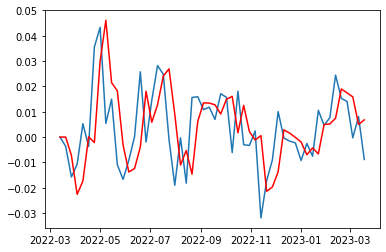

In [157]:
# ZAR
model_zar = ARIMA(week_exchange_df['ZAR_log_dif'], order=(2,2,1))
zar_results = model_zar.fit()
plt.plot(week_exchange_df.index, week_exchange_df['ZAR_log_dif'])
plt.plot(week_exchange_df.index, zar_results.fittedvalues, color='red')




In [165]:
currency_dif_list = ['ZAR_log_dif','MUR_log_dif', 'KSH_log_dif', 'NRA_log_dif', 'MZM_log_dif', 'BPU_log_dif']
currency_orders_list = [(2,2,1),(2,1,1),(2,3,1),(2,3,1),(18,3,1),(3,2,1)]

for i in range(len(currency_list)):
  model = ARIMA(week_exchange_df[currency_dif_list[i]], order=currency_orders_list[i])
  model_results = model.fit()

  week_exchange_df[f'{currency_dif_list[i]}_pred'] = np.array(model_results.fittedvalues)

In [166]:
week_exchange_df.head()

,ZAR,MUR,KSH,NRA,MZM,BPU,ZAR_log,MUR_log,KSH_log,NRA_log,...,KSH_log_dif,NRA_log_dif,MZM_log_dif,BPU_log_dif,ZAR_log_dif_pred,MUR_log_dif_pred,KSH_log_dif_pred,NRA_log_dif_pred,MZM_log_dif_pred,BPU_log_dif_pred
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-13,15.030000,44.490000,114.175000,415.745000,63.835000,11.560000,2.710048,3.795264,4.737732,6.030072,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-03-20,14.975714,44.337143,114.257143,415.692857,63.815714,11.584286,2.706430,3.791823,4.738452,6.029947,...,0.000719,-0.000125,-0.000302,0.002099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-03-27,14.741429,44.360000,114.467143,415.705714,63.814286,11.528571,2.690662,3.792338,4.740288,6.029978,...,0.001836,0.000031,-0.000022,-0.004821,-0.007237,-0.001663,0.001798,-0.000314,-0.000755,0.004197
2022-04-03,14.584286,44.707143,114.958571,415.841429,63.811429,11.458571,2.679945,3.800133,4.744572,6.030304,...,0.004284,0.000326,-0.000045,-0.006090,-0.022585,-0.001076,0.003351,0.000469,0.000839,-0.006793
2022-04-10,14.661429,44.918571,115.160000,415.467143,63.821429,11.521429,2.685220,3.804851,4.746322,6.029404,...,0.001751,-0.000900,0.000157,0.005471,-0.017404,0.001141,0.007414,0.000858,-0.000369,-0.007340


ZAR_log_dif
MUR_log_dif
KSH_log_dif
NRA_log_dif
MZM_log_dif
BPU_log_dif


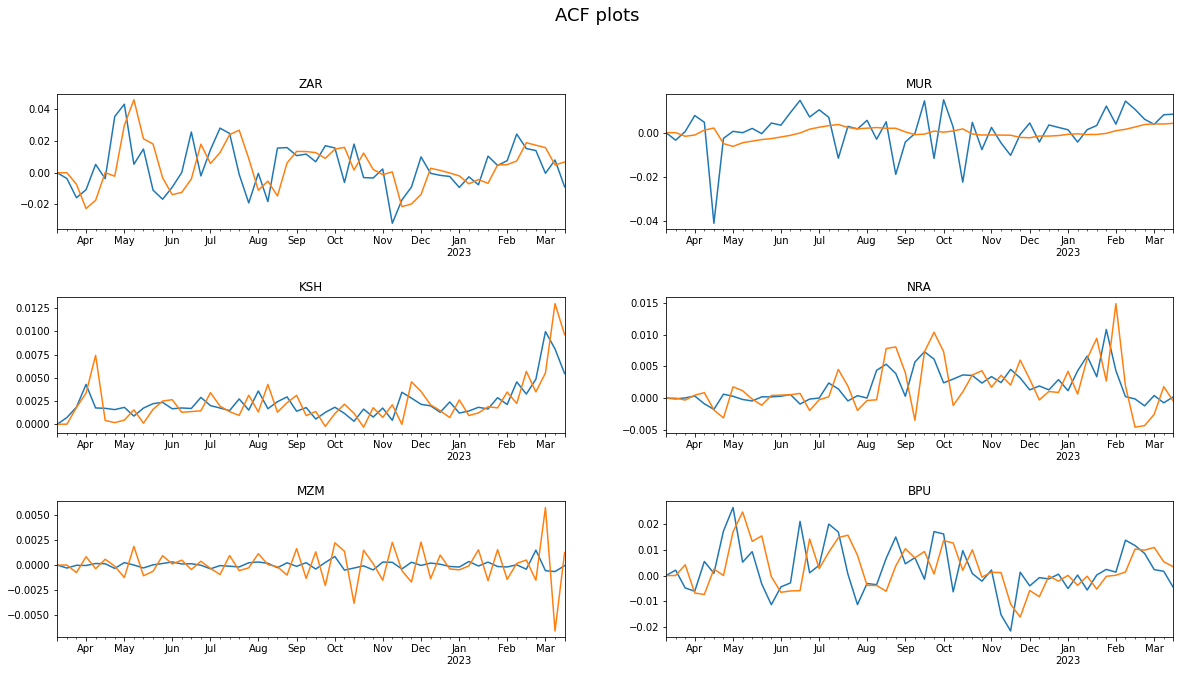

In [171]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('ARIMA plots', fontsize=18,y=1)
# loop through the length of currencies and keep track of index
for  i in range(len(currency_dif_list)):
  # add new subplot iteratively
  ax = plt.subplot(3,2,i+1)
  print(currency_dif_list[i])
  week_exchange_df.plot(y = f'{currency_dif_list[i]}', ax=ax, use_index=True, legend=None)
  week_exchange_df.plot(y=f'{currency_dif_list[i]}_pred',ax=ax, use_index=True,legend=None)
  # chart formating
  ax.set_title(currency_list[i].upper())
  # ax.get_legend().remove()
  ax.set_xlabel("")

Plot the residuals 

                               SARIMAX Results                                
Dep. Variable:            ZAR_log_dif   No. Observations:                   54
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 140.355
Date:                Tue, 14 Mar 2023   AIC                           -272.711
Time:                        12:09:35   BIC                           -264.906
Sample:                    03-13-2022   HQIC                          -269.718
                         - 03-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3469      0.165     -2.103      0.035      -0.670      -0.024
ar.L2         -0.0968      0.119     -0.815      0.415      -0.329       0.136
ma.L1         -0.9928      1.059     -0.937      0.3

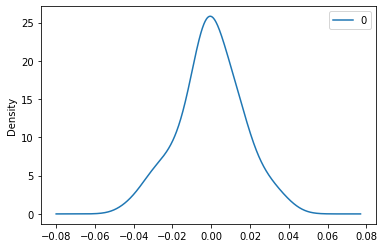

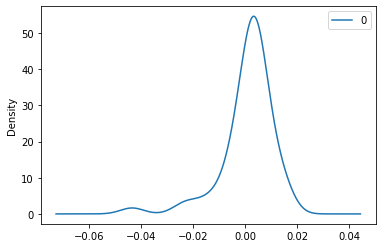

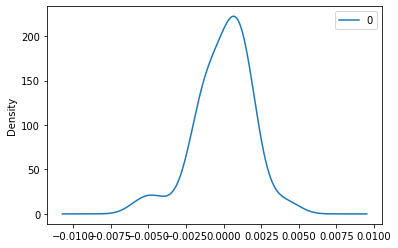

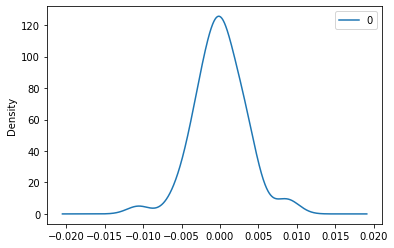

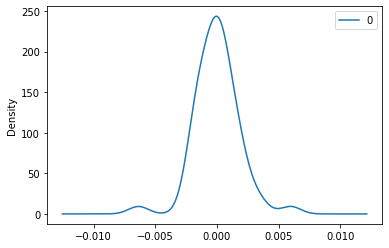

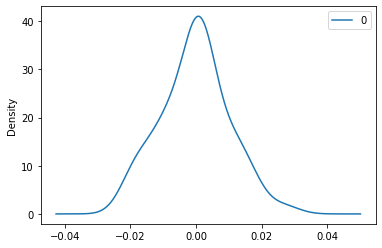

In [172]:
for i in range(len(currency_list)):
  model = ARIMA(week_exchange_df[currency_dif_list[i]], order=currency_orders_list[i])
  model_results = model.fit()
  print(model_results.summary())
  residuals = pd.DataFrame(model_results.resid)
  residuals.plot(kind='kde')
  print(residuals.describe())

In [173]:
# scale predictions back to original
def rescale(unscaled_series, unscaled_series_log):
  # calculate cumulative sum - why?
  unscaled_series_cumsum = unscaled_series.cumsum()
  unscaled_series_log = pd.Series(unscaled_series_log.iloc[0], index = unscaled_series_log.index)
  unscaled_series_log = unscaled_series_log.add(unscaled_series_cumsum,fill_value=0)
  unscaled_series_ = np.exp(unscaled_series_log)
  return unscaled_series_


In [179]:
week_exchange_df.head()

,ZAR,MUR,KSH,NRA,MZM,BPU,ZAR_log,MUR_log,KSH_log,NRA_log,...,KSH_log_dif,NRA_log_dif,MZM_log_dif,BPU_log_dif,ZAR_log_dif_pred,MUR_log_dif_pred,KSH_log_dif_pred,NRA_log_dif_pred,MZM_log_dif_pred,BPU_log_dif_pred
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-13,15.030000,44.490000,114.175000,415.745000,63.835000,11.560000,2.710048,3.795264,4.737732,6.030072,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-03-20,14.975714,44.337143,114.257143,415.692857,63.815714,11.584286,2.706430,3.791823,4.738452,6.029947,...,0.000719,-0.000125,-0.000302,0.002099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-03-27,14.741429,44.360000,114.467143,415.705714,63.814286,11.528571,2.690662,3.792338,4.740288,6.029978,...,0.001836,0.000031,-0.000022,-0.004821,-0.007237,-0.001663,0.001798,-0.000314,-0.000755,0.004197
2022-04-03,14.584286,44.707143,114.958571,415.841429,63.811429,11.458571,2.679945,3.800133,4.744572,6.030304,...,0.004284,0.000326,-0.000045,-0.006090,-0.022585,-0.001076,0.003351,0.000469,0.000839,-0.006793
2022-04-10,14.661429,44.918571,115.160000,415.467143,63.821429,11.521429,2.685220,3.804851,4.746322,6.029404,...,0.001751,-0.000900,0.000157,0.005471,-0.017404,0.001141,0.007414,0.000858,-0.000369,-0.007340


In [178]:
zar_arima_diff = pd.Series(week_exchange_df['ZAR_log_dif_pred'], copy=True)
zar_log = week_exchange_df['ZAR_log']

In [177]:
zar_pred_arima = rescale(zar_arima_diff, week_exchange_df['ZAR_log'] )

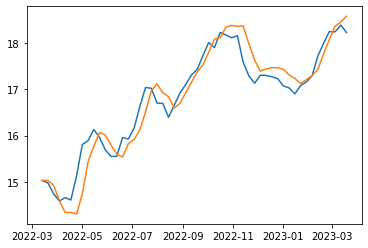

In [180]:
plt.plot(week_exchange_df.index, week_exchange_df['ZAR'])
plt.plot(week_exchange_df.index, zar_pred_arima)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ESfrom statsmodels.tsa.holtwinters import ExponentialSmoothing as ES

In [181]:
week_exchange_df.shape

(54, 24)

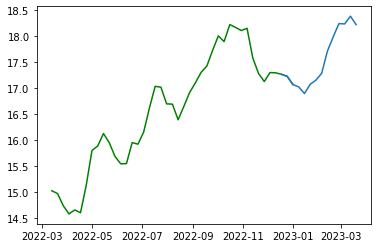

In [196]:
# train and test split
dataset_length = week_exchange_df.shape[0]
train_split = int(0.8*dataset_length)
train_set, test_set = week_exchange_df['ZAR'][0:train_split], week_exchange_df['ZAR'][train_split-3:]
plt.plot(train_set,color="green")
plt.plot(test_set)

In [197]:
test_set

Date
2022-12-18    17.270291
2022-12-25    17.230163
2023-01-01    17.071479
2023-01-08    17.028235
2023-01-15    16.899598
2023-01-22    17.078491
2023-01-29    17.157847
2023-02-05    17.289661
2023-02-12    17.717551
2023-02-19    17.990637
2023-02-26    18.245043
2023-03-05    18.239384
2023-03-12    18.387088
2023-03-19    18.225102
Name: ZAR, dtype: float64

In [203]:
model = ARIMA(train_set, order=(2,2,1))
result = model.fit()
forecast = result.forecast(4)

In [204]:
forecast

2023-01-08    17.001578
2023-01-15    16.876035
2023-01-22    16.779267
2023-01-29    16.671714
Freq: W-SUN, Name: predicted_mean, dtype: float64